# Model Assertion Framework for Trading Strategy

In [76]:
# Setting environment
# imports & settings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

#FeatureEngineering
from talib import RSI, BBANDS, MACD, ATR, MA, MIDPRICE

#GetStrategy
import xgboost as xgb

#ValidateStrategy
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.metrics import r2_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import DBSCAN
import hdbscan

## PART A: DATA GENERATION

#### A-1. Get Financial Data

In [77]:
class get_yfinance_data:
    def __init__(self, ticker_symbol, start_date, end_date):
        self.ticker_symbol = ticker_symbol
        self.start_date = start_date
        self.end_date = end_date
        # get daily financial data from yahoo finance api
        self.df = yf.download(self.ticker_symbol, 
                      start='2000-01-01', 
                      end='2022-05-01', 
                      progress=False)
    def add_techical_indicators(self):
        new_df = self.df
        
        # date
        new_df['year'] = new_df.index.get_level_values('Date').year
        new_df['month'] = new_df.index.get_level_values('Date').month
        
        #moving average
        new_df['MA'] = MA(new_df.Close, timeperiod=30, matype=0)
        
        # MIDPRICE - Midpoint Price over period
        new_df['MIDPRICE'] = MIDPRICE(new_df.High, new_df.Low, timeperiod=14)
        
        # Rolling Average Dollar Volume
        new_df['dollar_vol'] = new_df[['Close', 'Volume']].prod(axis=1)
        new_df['dollar_vol_1m'] = (new_df.dollar_vol
                                .rolling(window=30)
                                .mean()).values
        
        # Bollinger Bands
        new_df['upperband'],new_df['middleband'],new_df['lowerband'] = BBANDS(new_df.Close, 
                                                                     timeperiod=5, 
                                                                     nbdevup=2, 
                                                                     nbdevdn=2, 
                                                                     matype=0)
        # Momentum Indicators
        new_df['RSI'] = RSI(new_df.Close, timeperiod=14)
        new_df['MACD'] = MACD(new_df.Close, fastperiod=12, slowperiod=26, signalperiod=9)[0]
        new_df['ATR'] = ATR(new_df.High, new_df.Low, new_df.Close, timeperiod=14)
        
        new_df.dropna(inplace=True)
        
        return new_df


In [78]:
yfin_data = get_yfinance_data('SPY', '2000-01-01', '2022-05-01')

In [79]:
yfin_data.df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03 00:00:00-05:00,148.250000,148.250000,143.875000,145.437500,95.746468,8164300
2000-01-04 00:00:00-05:00,143.531250,144.062500,139.640625,139.750000,92.002182,8089800
2000-01-05 00:00:00-05:00,139.937500,141.531250,137.250000,140.000000,92.166794,12177900
2000-01-06 00:00:00-05:00,139.625000,141.500000,137.750000,137.750000,90.685524,6227200
2000-01-07 00:00:00-05:00,140.312500,145.750000,140.062500,145.750000,95.952179,8066500
...,...,...,...,...,...,...
2022-04-25 00:00:00-04:00,423.670013,428.690002,418.839996,428.510010,424.921417,119647700
2022-04-26 00:00:00-04:00,425.829987,426.040009,416.070007,416.100006,412.615356,103996300
2022-04-27 00:00:00-04:00,417.239990,422.920013,415.010010,417.269989,413.775543,122030000


In [80]:
yfin_data = yfin_data.add_techical_indicators()

In [81]:
yfin_data.head(1)

,Open,High,Low,Close,Adj Close,Volume,year,month,MA,MIDPRICE,dollar_vol,dollar_vol_1m,upperband,middleband,lowerband,RSI,MACD,ATR
Date,,,,,,,,,,,,,,,,,,
2000-02-18 00:00:00-05:00,138.875,138.875,134.625,135.3125,89.080818,9409200,2000,2,142.049479,139.59375,1.273182e+09,1.089854e+09,142.430631,138.634375,134.838119,37.603618,-1.660413,2.967091


#### A-2. Build ML-based Trading Strategy

In [82]:
class Strategy_generation:
    def __init__(self, df_stock, split_date):
        self.split_date = split_date
        self.df_stock = df_stock
        # we shift -1 because we want to predict the price of the next day
        self.df_stock['y'] = self.df_stock['Close'].shift(-1)
        X = self.df_stock.dropna()
        y = X['y']
        X = X.drop('y', axis = 1)
        # Train test split
        self.X_train, self.X_test = X[X.index < self.split_date], X[X.index >= self.split_date]
        self.y_train, self.y_test = y[y.index < self.split_date], y[y.index >= self.split_date]

    def train_XgbRegressor(self):
        '''
        We train on all the technical indicators we created from the feature engineering steps
        '''
        base = xgb.XGBRegressor()
        model = base.fit(self.X_train, self.y_train.values.ravel())
        self.model = model
        return model

    def run_XgbRegressor(self):
        ypred = self.model.predict(self.X_test)
        ypred_s = pd.Series(ypred, self.y_test.index)
        result = pd.concat([ypred_s, self.y_test], axis=1)
        result.columns = ['y_pred','y_test']
        self.ypred_s = ypred_s
        self.result = result
        return result


In [83]:
strat = Strategy_generation(yfin_data, '2016-01-01')

In [84]:
strat.train_XgbRegressor()

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [85]:
result = strat.run_XgbRegressor()
result.head(1)

,y_pred,y_test
Date,,
2016-01-04 00:00:00-05:00,199.086456,201.360001


#### A-3. Validate Strategy and Generate Error Metric Data


In [86]:
class ValidateStrategy:
    '''
    Given y_pred and y_test, calculate ['MAE','MSE', 'MAPE', 'sMAPE' ] for each single day in a rolling base
    '''
    def metric(data):
        '''
        data: DataFrame containing Date, y_test and y_pred
        '''
        test = data.y_test
        pred = data.y_pred
        d = [('MAE', mean_absolute_error(test, pred)),
             ('MSE', mean_squared_error(test, pred)),
             ('MAPE', mean_absolute_percentage_error(test, pred, symmetric=False)),
             ('sMAPE', mean_absolute_percentage_error(test, pred, symmetric=True))]
        data_new = pd.DataFrame(d, columns=['Metrics', 'Value']).set_index('Metrics')
        return data_new
    def get_metric(w,i,df):  
        '''
        Calculate error metrics for each single day
        w: rolling window for calculating error metrics. In other words, w days before i.
        i: the index of the day we want to calculate error metrics
        df: DataFrame containing Date, y_test and y_pred
        (If i is smaller than w, just use the days it has before i.)
        '''
        if i >= w:
            start = i-w+1
            end = i+1
            return ValidateStrategy.metric(df.iloc[start:end,1:])
        else: 
            return ValidateStrategy.metric(df.iloc[:i+1,1:])
    def get_df(window,df_result):
        '''
        Combine error metrics of all days into one DataFrame
        window: rolling window for calculating error metrics.
        df_result:DataFrame containing Date, y_test and y_pred
        '''
        df_result = df_result.reset_index()
        for index in df_result.index:
            df_result.loc[index,'MAE'] = ValidateStrategy.get_metric(w=window, i=index, df=df_result).loc['MAE','Value']
            df_result.loc[index,'MSE'] = ValidateStrategy.get_metric(w=window, i=index, df=df_result).loc['MSE','Value']
            df_result.loc[index,'MAPE'] = ValidateStrategy.get_metric(w=window, i=index, df=df_result).loc['MAPE','Value']
            df_result.loc[index,'sMAPE'] = ValidateStrategy.get_metric(w=window, i=index, df=df_result).loc['sMAPE','Value']
        return df_result

In [87]:
DF_SPY_result_Valid = ValidateStrategy.get_df(30,result)
DF_SPY_result_Valid.head(1)

,Date,y_pred,y_test,MAE,MSE,MAPE,sMAPE
0,2016-01-04 00:00:00-05:00,199.086456,201.360001,2.273544,5.169004,0.011291,0.011355


## PART B: Model Assertion

#### B-1. EDA

<AxesSubplot:xlabel='Date'>

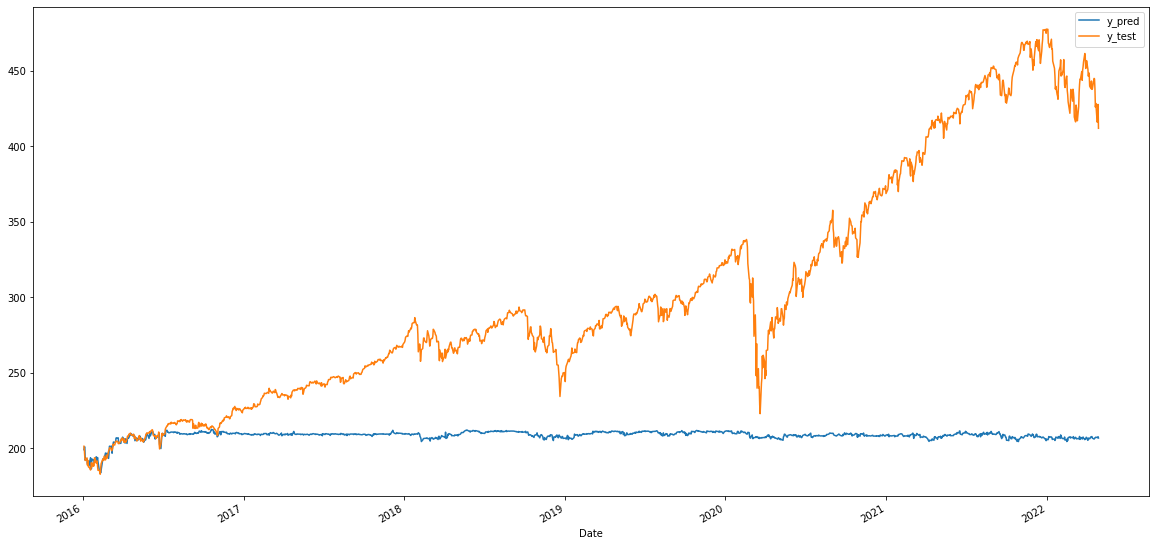

In [88]:
result.plot(figsize=(20, 10))

In [89]:
DF_SPY_result_Valid.head(1)

,Date,y_pred,y_test,MAE,MSE,MAPE,sMAPE
0,2016-01-04 00:00:00-05:00,199.086456,201.360001,2.273544,5.169004,0.011291,0.011355


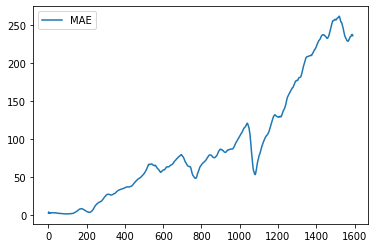

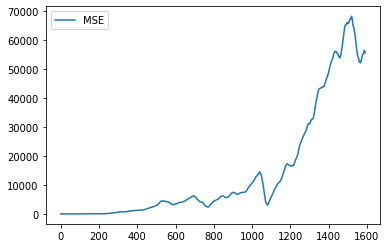

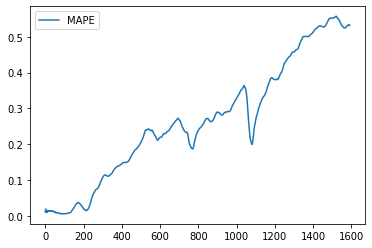

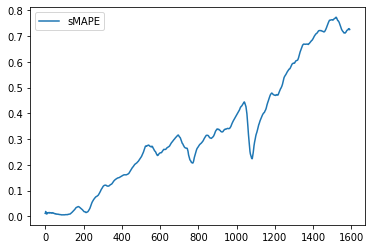

In [90]:
DF_SPY_result_Valid[['MAE']].plot()
plt.show()
DF_SPY_result_Valid[['MSE']].plot()
plt.show()
DF_SPY_result_Valid[['MAPE']].plot()
plt.show()
DF_SPY_result_Valid[['sMAPE']].plot()
plt.show()

#### B-2. Model Assetion Framework

In [91]:
class ModelAssertion:
    '''
    Use different machine learning models to detect a huge surge in error metrics
    window_out_train: length of the period to train different models
    window_out_test: length of the period to test different models
    '''
    def __init__(self,df_result,window_me):
        '''
        df_result: DataFrame contains ['Date','MAE','MSE', 'MAPE', 'sMAPE']
        window_me: length of the period to calculate error metrics
        '''
        self.df_result = df_result 
        self.df_Valid = ValidateStrategy.get_df(window_me,df_result)
   
    def outlier_mean_std(self,window_out_train,window_out_test):
        '''
        model assertion warning: 
        the mean of all error metrics in test are larger than the mean + 3* std of all error metrcs in train
        '''
        X = self.df_Valid[['MAE','MSE', 'MAPE', 'sMAPE' ]]
        X_train = X[:window_out_train]
        thres = 3*X_train.std()+X_train.mean()
        for index in range(window_out_train+window_out_test,len(self.df_Valid)-1):
            X_test = X[index-window_out_test:index]
            X_test_mean = X_test.mean()
            test_result = X_test_mean>thres
            if (test_result == True).all() == True:
                print(self.df_Valid.loc[index, 'Date'])
                break

    def outlier_iso_forest(self,window_out_train,window_out_test):
        '''
        model assertion warning: 
        1. Normalize train and test dataset
        2. Train isolation forest in train datasets. 
        3. If all datapoints in test datasets are detected as outliers by isolation forest moodels, break!
        '''
        X = self.df_Valid[['MAE','MSE', 'MAPE', 'sMAPE' ]]
        X_train = X[:window_out_train]
        #use train datasets to train StandardScaler
        scaler_1 = StandardScaler()
        scaler_1.fit(np.array(X_train['MAE']).reshape(-1,1))
        scaler_2 = StandardScaler()
        scaler_2.fit(np.array(X_train['MSE']).reshape(-1,1))
        scaler_3 = StandardScaler()
        scaler_3.fit(np.array(X_train['MAPE']).reshape(-1,1))
        scaler_4 = StandardScaler()
        scaler_4.fit(np.array(X_train['sMAPE']).reshape(-1,1))
        X_train['MAE'] = X_train['MAE'].apply(lambda x: scaler_1.transform(np.array(x).reshape(-1,1))[0][0])
        X_train['MSE'] = X_train['MSE'].apply(lambda x: scaler_2.transform(np.array(x).reshape(-1,1))[0][0])
        X_train['MAPE'] = X_train['MAPE'].apply(lambda x: scaler_3.transform(np.array(x).reshape(-1,1))[0][0])
        X_train['sMAPE'] = X_train['sMAPE'].apply(lambda x: scaler_4.transform(np.array(x).reshape(-1,1))[0][0])
        clf = IsolationForest(random_state=0).fit(X_train)
        for index in range(window_out_train+window_out_test,len(self.df_Valid)-1):
            X_test = X[index-window_out_test:index]
            #apply trained StandardScaler to test datasets
            X_test['MAE'] = X_test['MAE'].apply(lambda x: scaler_1.transform(np.array(x).reshape(-1,1))[0][0])
            X_test['MSE'] = X_test['MSE'].apply(lambda x: scaler_2.transform(np.array(x).reshape(-1,1))[0][0])
            X_test['MAPE'] = X_test['MAPE'].apply(lambda x: scaler_3.transform(np.array(x).reshape(-1,1))[0][0])
            X_test['sMAPE'] = X_test['sMAPE'].apply(lambda x: scaler_4.transform(np.array(x).reshape(-1,1))[0][0])
            test_result = clf.predict(X_test).tolist()
            #check if all datapoints in test datasets are detected as outliers
            if all(i == -1 for i in test_result) == True:
                print(self.df_Valid.loc[index, 'Date'])
                break
    def outlier_dbscan(self, window_out_train,window_out_test):
        '''
        model assertion warning: 
        1. Combine train and test dataseat together 
        2. Normalize combined dataset and use dbscan to assign combined data into different groups
        3. If groups in train and test datasets are completely different, break!
        '''
        X = self.df_Valid[['MAE','MSE', 'MAPE', 'sMAPE' ]]
        for index in range(window_out_train+window_out_test,len(self.df_Valid)-1):
            #combine train and test data
            X = pd.concat([DF_SPY_result_Valid[['MAE','MSE', 'MAPE', 'sMAPE' ]][:window_out_train],\
                           DF_SPY_result_Valid[['MAE','MSE', 'MAPE', 'sMAPE' ]][index-window_out_test:index]])
            #Normalize
            for i in ['MAE','MSE', 'MAPE', 'sMAPE' ]:
                scaler = StandardScaler()
                scaler.fit(np.array(X[i]).reshape(-1,1))
                X[i] = X[i].apply(lambda x: scaler.transform(np.array(x).reshape(-1,1))[0][0])
            #Train model
            dbscan=DBSCAN()
            model = dbscan.fit(X)
            #get unique groups of train and test data
            train_result = model.labels_[:window_out_train].tolist()
            test_result = model.labels_[-window_out_test:].tolist()
            train_unique = list(set(train_result))
            train_unique.remove(-1) if -1 in train_unique else None
            test_unique = list(set(test_result))
            test_unique.remove(-1) if -1 in test_unique else None
            #print(model.labels_)
            #print(train_unique,test_unique)
            #check if groups in train and test datasets are completely different
            if any(x in test_unique for x in train_unique)==False:
                print(self.df_Valid.loc[index, 'Date'])
                break
    def outlier_hdbscan(self, window_out_train,window_out_test):
        '''
        model assertion warning: 
        1. Combine train and test dataseat together 
        2. Normalize combined dataset and use dbscan to assign combined data into different groups
        3. If groups in train and test datasets are completely different, break!
        '''
        X = self.df_Valid[['MAE','MSE', 'MAPE', 'sMAPE' ]]
        for index in range(window_out_train+window_out_test,len(self.df_Valid)-1):
            #combine train and test data
            X = pd.concat([DF_SPY_result_Valid[['MAE','MSE', 'MAPE', 'sMAPE' ]][:window_out_train],\
                           DF_SPY_result_Valid[['MAE','MSE', 'MAPE', 'sMAPE' ]][index-window_out_test:index]])
            #Normalize
            for i in ['MAE','MSE', 'MAPE', 'sMAPE' ]:
                scaler = StandardScaler()
                scaler.fit(np.array(X[i]).reshape(-1,1))
                X[i] = X[i].apply(lambda x: scaler.transform(np.array(x).reshape(-1,1))[0][0])
            #Train model
            clusterer = hdbscan.HDBSCAN()
            model = clusterer.fit(X)
            #get unique groups of train and test data
            train_result = model.labels_[:window_out_train].tolist()
            test_result = model.labels_[-window_out_test:].tolist()
            train_unique = list(set(train_result))
            train_unique.remove(-1) if -1 in train_unique else None
            test_unique = list(set(test_result))
            test_unique.remove(-1) if -1 in test_unique else None
            #print(model.labels_)
            #print(train_unique,test_unique)
            if any(x in test_unique for x in train_unique)==False:
                print(self.df_Valid.loc[index, 'Date'])
                break

In [92]:
ModelAssertion(df_result = DF_SPY_result_Valid,window_me = 30).outlier_mean_std(window_out_train =100,window_out_test = 30)

2016-08-23 00:00:00-04:00


In [93]:
ModelAssertion(df_result = DF_SPY_result_Valid,window_me = 30).outlier_iso_forest(window_out_train =100,window_out_test = 30)

2016-09-01 00:00:00-04:00


In [94]:
ModelAssertion(df_result = DF_SPY_result_Valid,window_me = 30).outlier_dbscan(window_out_train =100,window_out_test = 30)

2016-09-15 00:00:00-04:00


In [95]:
ModelAssertion(df_result = DF_SPY_result_Valid,window_me = 30).outlier_hdbscan(window_out_train =100,window_out_test = 30)

2016-08-29 00:00:00-04:00
